# Eden Hazard's Dribble Performance in World Cup 2018

## Outlline
- Get data: stack all the event data for Belgium
- Initial Processing:
  - Get all Eden Hazard's `Dribble Event` - Have a quick view of Eden's dribble completion by match
  - Divide dribbles into two groups based on outcomes (Complete & Incomplete).
  - `Group Incomplete` is all set while `Group Complete` needs a further exploration focused on `Post-Dribble Actions`
-  Dive deep into successful dribbles and their consequences
  - Exploratory analysis: move the next four actions after a dribble made by Eden to the same row with that dribble
    - Finding: All completed dribble comes with a subsequent ball `carry`, and that `carry` ends up in `Shot`/`Pass`/`Foul Won`/`Possesion Lost`/Another `Dribble`
   - Deal with `Post-Dribble Actions`
     - `Carry`: Edit directly on `Group Complete`
       1. Form a new DataFrame using the sequence of Dribble-Carry
       2. Fill the NaNs of end points' coordinates in dribble rows with carry-end coordinates
       3. Keep only dribbles rows since there's no null values now
     - `Pass`:
       1. Same first step
       2. Fill in the null outcomes with 'Complete'
     - `Shot`: 
       1. Same first step
     - `Foul Won`: 
       1. Same first step
     - `Possesion Lost`: 
       1. Same first step
     - `Dribble`: Just ignore it or it'll cause duplication
       1. Same first step

- Troubleshooting (TBD):
  - The data I get seems less than the number of dirbble Eden Hazard actually made in WC 2018
  - Doublecheck with another data source (Wyscout)
- Visualization
  - Plot Eden Hazard's dribbles and post-dribble actions using different icons and lines

## Get Data

In [1]:
from mplsoccer import Sbopen, Pitch, VerticalPitch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
parser = Sbopen()

In [3]:
matches = parser.match(competition_id=43, season_id=3)
bel_matches = matches.loc[(matches['away_team_name'] == 'Belgium') |
                          (matches['home_team_name'] == 'Belgium')]
bel_matches.sort_values('match_date')

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
12,7536,2018-06-18,2018-06-18 17:00:00,3,0,available,scheduled,2021-12-06 22:40:10.487423,2021-06-13 16:17:31.694,1,...,10,Group Stage,249,\tOlimpiyskiy Stadion Fisht,188,Russia,743,Janny Sikazwe,253,Zambia
43,7552,2018-06-23,2018-06-23 14:00:00,5,2,available,scheduled,2023-07-24 12:59:24.671811,2021-06-13 16:17:31.694,2,...,10,Group Stage,4130,Otkritie Bank Arena,188,Russia,428,Jair Marrufo,241,United States of America
1,7570,2018-06-28,2018-06-28 20:00:00,0,1,available,scheduled,2023-07-24 13:06:39.637575,2021-06-13 16:17:31.694,3,...,10,Group Stage,4260,Stadion Kaliningrad,188,Russia,420,Damir Skomina,208,Slovenia
36,7584,2018-07-02,2018-07-02 20:00:00,3,2,available,scheduled,2023-07-24 13:04:21.430916,2021-06-13 16:17:31.694,4,...,33,Round of 16,256,\tRostov Arena,188,Russia,732,Malang Diedhiou,202,Senegal
22,8650,2018-07-06,2018-07-06 20:00:00,1,2,available,scheduled,2023-07-24 13:07:31.588643,2021-06-13 16:17:31.694,5,...,11,Quarter-finals,4258,Ak Bars Arena,188,Russia,727,Milorad Mažić,203,Serbia
57,8655,2018-07-10,2018-07-10 20:00:00,1,0,available,scheduled,2023-07-24 13:00:27.503953,2021-06-13 16:17:31.694,6,...,15,Semi-finals,4726,Saint-Petersburg Stadium,188,Russia,734,Andrés Cunha,242,Uruguay
58,8657,2018-07-14,2018-07-14 16:00:00,2,0,available,scheduled,2023-07-24 13:02:46.901265,2021-06-13 16:17:31.694,7,...,25,3rd Place Final,4726,Saint-Petersburg Stadium,188,Russia,741,Alireza Faghani,107,"Iran, Islamic Republic of"


In [4]:
# stack all Belgium's matches
bel = pd.DataFrame(columns=['match_id','type_name','sub_type_name','team_name', 'player_name',
       'end_x', 'end_y', 'x', 'y', 'outcome_name'])
for id in bel_matches.match_id:
    event = parser.event(match_id=id)[0]
    bel_event = event.loc[event['team_name']=='Belgium'][['match_id','type_name','sub_type_name','team_name', 'player_name','end_x', 'end_y', 'x', 'y', 'outcome_name']]
    bel = bel._append(bel_event,ignore_index=True)


In [5]:
# drop team_name column
bel.drop('team_name',axis=1,inplace=True)

In [6]:
# keep only Hazard's dribbles
eden = bel.loc[(bel['player_name']=='Eden Hazard') & (bel['type_name']=='Dribble')]

In [7]:
eden.groupby(['match_id','outcome_name']).size().unstack(fill_value=0)

outcome_name,Complete,Incomplete
match_id,,
7536,1,5
7552,2,1
7584,3,2
8650,9,0
8655,7,1
8657,6,5


## Data Wrangling

### Deal with incomplete dribbles

In [8]:
incomplete = eden.loc[eden['outcome_name']=='Incomplete'] # scatter plot the incomplete ones so no other actions needed

### Deal with complete ones
- A successful take-on comes with a ball carry -- that provides us with dribble-end coordinate to plot a route
- Explore if there's a subsequent -- the dribble ended up as a foul won / goal / ...
- Do that by forward-tracking method
- Form those subsequences into DataFrame with original index reserved

In [9]:
complete_dribble = eden.loc[eden['outcome_name']=='Complete']
inds = complete_dribble.index.values

In [10]:
# extract complete dribble with subsequent carry together
complete = pd.DataFrame(columns=complete_dribble.columns)
for ind in inds:
    complete = complete._append(bel.iloc[ind])
    complete = complete._append(bel.iloc[ind+1])

In [11]:
# replace dribble end coordinate with carry end coordinate, then remove carry rows
complete[['end_x','end_y']] = complete[['end_x','end_y']].fillna(complete[['end_x','end_y']].shift(-1))
complete = complete.loc[complete['type_name']=='Dribble']

In [12]:
complete.drop(['type_name','sub_type_name','player_name','outcome_name'],axis=1,inplace=True)

In [13]:
complete.head(10)

,match_id,end_x,end_y,x,y
4166,7536,92.0,15.0,95.0,5.0
4726,8650,56.0,8.0,59.0,13.0
4733,8650,94.0,52.0,70.0,14.0
4952,8650,68.0,6.0,73.0,7.0
5068,8650,72.0,16.0,65.0,23.0
5720,8650,90.0,48.0,23.0,50.0
5792,8650,70.0,58.0,68.0,62.0
5866,8650,56.0,42.0,35.0,48.0
5917,8650,58.0,54.0,50.0,75.0
5919,8650,83.0,78.0,58.0,54.0


## Post-Dribble Actions

In [14]:
# Get the indices of all completed dribbles
drib_inds = bel.loc[(bel['type_name'] == 'Dribble')
                    & (bel['outcome_name'] == 'Complete')].index

In [15]:
# Append the next four actions to the right
for i in range(4):
    bel[f'act_{i+1}'] = bel['type_name'].shift(-i-1)
    bel[f'player_{i+1}'] = bel['player_name'].shift(-i-1)

In [16]:
drib_next_4 = bel.loc[drib_inds][['player_name','act_1','player_1','act_2','player_2','act_3','player_3','act_4','player_4']]

In [17]:
pd.set_option('display.max_rows', 100)

In [18]:
drib_next_4

,player_name,act_1,player_1,act_2,player_2,act_3,player_3,act_4,player_4
229,Youri Tielemans,Carry,Youri Tielemans,Dispossessed,Youri Tielemans,Pressure,Nacer Chadli,Pressure,Youri Tielemans
640,Adnan Januzaj,Carry,Adnan Januzaj,Pass,Adnan Januzaj,Ball Receipt,Michy Batshuayi Tunga,Carry,Michy Batshuayi Tunga
817,Michy Batshuayi Tunga,Carry,Michy Batshuayi Tunga,Pass,Michy Batshuayi Tunga,Ball Receipt,Thorgan Hazard,Pressure,Marouane Fellaini-Bakkioui
890,Thorgan Hazard,Carry,Thorgan Hazard,Pass,Thorgan Hazard,Ball Receipt,Michy Batshuayi Tunga,Duel,Mousa Sidi Yaya Dembélé
896,Mousa Sidi Yaya Dembélé,Carry,Mousa Sidi Yaya Dembélé,Pass,Mousa Sidi Yaya Dembélé,Ball Receipt,Youri Tielemans,Carry,Youri Tielemans
1195,Michy Batshuayi Tunga,Carry,Michy Batshuayi Tunga,Pass,Michy Batshuayi Tunga,Ball Receipt,Adnan Januzaj,Carry,Adnan Januzaj
1206,Adnan Januzaj,Carry,Adnan Januzaj,Shot,Adnan Januzaj,Pressure,Adnan Januzaj,Pressure,Thorgan Hazard
1224,Marouane Fellaini-Bakkioui,Carry,Marouane Fellaini-Bakkioui,Pass,Marouane Fellaini-Bakkioui,Ball Receipt,Thorgan Hazard,Carry,Thorgan Hazard
1408,Marouane Fellaini-Bakkioui,Carry,Marouane Fellaini-Bakkioui,Pass,Marouane Fellaini-Bakkioui,Ball Receipt,Thorgan Hazard,Pressure,Mousa Sidi Yaya Dembélé
1979,Marouane Fellaini-Bakkioui,Carry,Marouane Fellaini-Bakkioui,Foul Won,Marouane Fellaini-Bakkioui,Carry,Marouane Fellaini-Bakkioui,Pass,Marouane Fellaini-Bakkioui


In [19]:
drib_next_4.groupby(['player_name','player_1','player_2','player_3','player_4']).count()

act_1  \
player_name                player_1                   player_2                   player_3                   player_4                            
Adnan Januzaj              Adnan Januzaj              Adnan Januzaj              Adnan Januzaj              Thorgan Hazard                  1   
                                                                                 Michy Batshuayi Tunga      Michy Batshuayi Tunga           1   
Axel Witsel                Axel Witsel                Axel Witsel                Eden Hazard                Eden Hazard                     2   
                                                                                 Jan Vertonghen             Jan Vertonghen                  1   
Eden Hazard                Eden Hazard                Eden Hazard                Dries Mertens              Dries Mertens                   2   
                                                                                                            Thomas Meunier                  1   
                                                                                                            Yannick Ferreira Carrasco       1   
                                                                                 Eden Hazard                Axel Witsel                     1   
                                                                                                            Eden Hazard                     5   
                                                                                 Kevin De Bruyne            Axel Witsel                     1   
                                                                                                            Eden Hazard                     1   
                                                                                                            Jan Vertonghen                  3   
                                                                                                            Kevin De Bruyne                 3   
                                                                                 Nacer Chadli               Nacer Chadli                    2   
                                                                                 Romelu Lukaku Menama       Romelu Lukaku Menama            1   
                                                                                 Thomas Meunier             Thomas Meunier                  1   
                                                                                 Thomas Vermaelen           Thomas Vermaelen                1   
                                                                                 Thorgan Hazard             Axel Witsel                     1   
                                                                                 Toby Alderweireld          Thibaut Courtois                1   
                                                                                 Vincent Kompany            Thomas Vermaelen                1   
Jan Vertonghen             Jan Vertonghen             Jan Vertonghen             Nacer Chadli               Eden Hazard                     1   
                                                                                 Vincent Kompany            Vincent Kompany                 1   
Kevin De Bruyne            Kevin De Bruyne            Kevin De Bruyne            Axel Witsel                Axel Witsel                     1   
                                                                                 Eden Hazard                Axel Witsel                     1   
                                                                                                            Eden Hazard                     2   
                                                                                                            Jan Vertonghen                  1   
                                                                            

In [20]:
drib_next_4.groupby(['act_1','act_2']).count()

player_name  player_1  player_2  act_3  player_3  act_4  \
act_1 act_2                                                                   
Carry Dispossessed            2         2         2      2         2      2   
      Dribble                11        11        11     11        11     11   
      Foul Won               12        12        12     12         8     12   
      Miscontrol              2         2         2      2         2      2   
      Pass                   44        44        44     44        44     44   
      Shot                    6         6         6      6         6      6   

                    player_4  
act_1 act_2                   
Carry Dispossessed         2  
      Dribble             11  
      Foul Won            11  
      Miscontrol           2  
      Pass                44  
      Shot                 6

In [21]:
# append the second actions after a dribble to the event dataframe (the consequent one is always a carry)
bel['act_2'] = bel['type_name'].shift(-2)
bel['player_2'] = bel['player_name'].shift(-2)

In [22]:
# extract post dribble actions by dribble indices
post_dribble = bel.loc[complete.index][['match_id','act_2','player_2']]

In [23]:
post_dribble.groupby('act_2').size()

act_2
Dribble        8
Foul Won       7
Miscontrol     1
Pass          11
Shot           1
dtype: int64

In [24]:
# fill null values
# form sub dataframes by actions (leave dribbles out because of duplicate)
# dribble led to pass
ind_dribble_pass = post_dribble[post_dribble['act_2']=='Pass'].index + 2
dribble_pass = bel.loc[ind_dribble_pass][['end_x','end_y','x','y','outcome_name']]

# dribble led to foul won
ind_dribble_foul = post_dribble[post_dribble['act_2']=='Foul Won'].index + 2
dribble_foul = bel.loc[ind_dribble_foul][['end_x','end_y','x','y','outcome_name']]

# dribble led to shot
ind_dribble_shot = post_dribble[post_dribble['act_2']=='Shot'].index + 2
dribble_shot = bel.loc[ind_dribble_shot][['end_x','end_y','x','y','outcome_name']]

# dribble ended up possesion lost
ind_dribble_lost = post_dribble[post_dribble['act_2']=='Miscontrol'].index + 2
dribble_lost = bel.loc[ind_dribble_lost][['end_x','end_y','x','y','outcome_name']]

In [25]:
# data cleansing
# for passes: fill nans with complete
dribble_pass.fillna('Complete',inplace=True)

# other three are all set

## Visualization

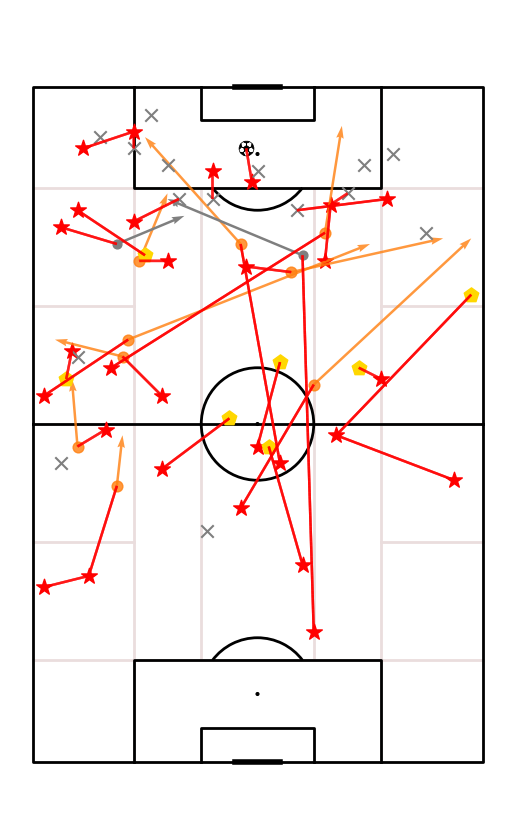

In [36]:
pitch = VerticalPitch('statsbomb', line_color='black',positional=True, positional_color='#eadddd', shade_color='#f2f2f2')
dpi = 2400
fig, ax = pitch.grid(grid_height=0.8,
                     title_height=0.06,
                     axis=False,
                     endnote_height=0.04,
                     title_space=0,
                     endnote_space=0)

# plot all completed dribbles with red circles
pitch.scatter(complete.x,
             complete.y,
             color='red',
             ax=ax['pitch'],
             marker = '*',
             s = 140
             )

# plot the ball carrying path
# for i in range(complete.shape[0]):
#     ax['pitch'].plot([complete.iloc[i].x, complete.iloc[i].end_x],
#                      [complete.iloc[i].y, complete.iloc[i].end_y],
#                     color = 'red',
#                     lw=1.8,
#                     alpha=0.8,
#                     linestyle='-.')



pitch.lines(complete.x,
            complete.y,
            complete.end_x,
            complete.end_y,
            color='red',
            lw=1.8,
            transparent= True,
            ax=ax['pitch'],
            alpha=0.8,
            linestyle = '-.')

# plot post_dribble passes with arrows (orange for completed ones and grey for incompleted ones)
pitch.arrows(dribble_pass[dribble_pass['outcome_name']=='Complete'].x,
             dribble_pass[dribble_pass['outcome_name']=='Complete'].y,
             dribble_pass[dribble_pass['outcome_name']=='Complete'].end_x,
             dribble_pass[dribble_pass['outcome_name']=='Complete'].end_y,
             color='tab:orange',
             ax=ax['pitch'],
             alpha=0.8,
             width=1.8)

pitch.scatter(dribble_pass[dribble_pass['outcome_name']=='Complete'].x,
             dribble_pass[dribble_pass['outcome_name']=='Complete'].y,
             color='tab:orange',
             ax=ax['pitch'],
             marker = 'o',
             s = 60,
             alpha = 0.8
             )

pitch.arrows(dribble_pass[dribble_pass['outcome_name']=='Incomplete'].x,
             dribble_pass[dribble_pass['outcome_name']=='Incomplete'].y,
             dribble_pass[dribble_pass['outcome_name']=='Incomplete'].end_x,
             dribble_pass[dribble_pass['outcome_name']=='Incomplete'].end_y,
             color='tab:gray',
             ax=ax['pitch'],
             alpha=1,
             width=1.8)

pitch.scatter(dribble_pass[dribble_pass['outcome_name']=='Incomplete'].x,
             dribble_pass[dribble_pass['outcome_name']=='Incomplete'].y,
             color='tab:gray',
             ax=ax['pitch'],
             marker = 'o',
             s = 40,
             alpha = 1
             )

# plot lost possesion and incomplete dribble with grey 'X'
pitch.scatter(dribble_lost.x,
             dribble_lost.y,
             color='tab:gray',
             ax=ax['pitch'],
             marker = 'x',
             s = 80,
             alpha = 1
             )

pitch.scatter(incomplete.x,
             incomplete.y,
             color='tab:gray',
             ax=ax['pitch'],
             marker = 'x',
             s = 80,
             alpha = 1
             )

# plot shots with a football icon
pitch.scatter(dribble_shot.x,
             dribble_shot.y,
             # color='grey',
             ax=ax['pitch'],
             marker = 'football',
             s = 120,
             alpha = 1
             )

# plot Foul Won with yellow pentagon
pitch.scatter(dribble_foul.x,
             dribble_foul.y,
             color='gold',
             ax=ax['pitch'],
             marker = 'p',
             s = 120,
             alpha = 1
             )

# fig.savefig('Eden Hazard 2018 World Cup.png', dpi=dpi)

## Exploratory Analysis

In [27]:
# Step 1: Group by match_id and outcome_name, and count the occurrences
dribble.groupby(['match_id', 'outcome_name']).size().unstack(fill_value=0)

NameError: name 'dribble' is not defined

In [ ]:
bel[bel['player_name']=='Eden Hazard'].groupby('type_name').size()

type_name
Ball Receipt      363
Ball Recovery      23
Block               7
Carry             322
Clearance           1
Dispossessed       13
Dribble            42
Dribbled Past       3
Duel                6
Foul Committed      7
Foul Won           32
Interception        6
Miscontrol         10
Pass              271
Pressure           99
Shot               18
Substitution        1
dtype: int64